In [1]:
import torch
from torchvision import models
import matplotlib.pyplot as plt
import importlib

# Load pretrained DeepLabV3 with a ResNet-101 backbone
# model = models.segmentation.deeplabv3_resnet101(pretrained=True)
# model.eval()  # Set to evaluation mode

In [ ]:
# segformer
# Stable release
!pip install numpy==1.26.4
!pip install transformers
# If you want PyTorch + Transformers
!pip install torch torchvision transformers

In [2]:
print("PASCAL VOC dataset")
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import InterpolationMode

# Paths
im_size = 512
voc_root = "dataset/"   # NOT dataset/VOC2012
year = "2012"
image_set = "train"
img_size = im_size

# Transforms for both images and masks
transform_img = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BILINEAR),
    transforms.PILToTensor(),
])

transform_target = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=InterpolationMode.NEAREST),
       transforms.PILToTensor()   # keeps mask as integer labels (0..21)
])

def transform_target_fn(mask):
    mask = transforms.Resize((img_size, img_size), interpolation=InterpolationMode.NEAREST)(mask)
    mask = transforms.PILToTensor()(mask)  # tensor [1, H, W] with values {0..21, 255}
    mask = mask.squeeze(0)                 # remove channel dim
    mask = torch.where(mask == 255, torch.tensor(0, dtype=mask.dtype), mask)
    return mask
# Dataset
train_dataset = VOCSegmentation(root=voc_root,year=year,image_set=image_set,download=False,transform=transform_img,target_transform=transform_target_fn)

# DataLoader
trainloader = DataLoader(train_dataset,batch_size=4,shuffle=True,num_workers=4,drop_last=True)

PASCAL VOC dataset


In [2]:
# citiscape  dataset
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode

print('Dataloader for citiscape dataset')

im_size = 512  # example size
# Mapping from raw Cityscapes IDs to trainId+1
id_to_trainid_plus1 = {
    7: 1, 8: 2, 11: 3, 12: 4, 13: 5, 17: 6,19: 7, 20: 8, 21: 9, 22: 10, 23: 11, 24: 12, 25: 13, 26: 14, 27: 15, 28: 16, 31: 17, 32: 18, 33: 19}

def convert_cityscapes_target_torch(mask: torch.Tensor) -> torch.Tensor:
    """
    Convert raw Cityscapes label IDs to:
      ignored → 0
      trainId+1 → 1..19
    """
    mapped = torch.zeros_like(mask, dtype=torch.uint8)
    for raw_id, new_id in id_to_trainid_plus1.items():
        mapped[mask == raw_id] = new_id
    return mapped
# Transforms for images # same as train_transform_no_np
transform_img = transforms.Compose([
    transforms.Resize((im_size, im_size), interpolation=InterpolationMode.BILINEAR),
    transforms.PILToTensor()  # uint8 tensor [C,H,W] 
    ])
# Transforms for masks
def target_transform(mask):
    mask = transforms.Resize((im_size, im_size), interpolation=InterpolationMode.NEAREST)(mask)
    mask = transforms.PILToTensor()(mask).squeeze(0)  # remove channel dim → [H,W]
    return convert_cityscapes_target_torch(mask)      # apply mapping
# Dataset
cityscapes_train = datasets.Cityscapes(
    root='dataset/CityScapes',
    split='train',
    mode='fine',
    target_type='semantic',
    transform=transform_img,
    target_transform=target_transform)
# DataLoader
trainloader = torch.utils.data.DataLoader(
    cityscapes_train,
    batch_size=4,
    shuffle=True,
    num_workers=4, drop_last=True)

Dataloader for citiscape dataset


In [4]:
# dataloader

print('This will give you dataset of ade20k challenge with 150')


import data.ade20k_challenges
importlib.reload(data.ade20k_challenges)
from data.ade20k_challenges import ADE20k_challange
from torchvision import transforms, datasets
from torchvision.transforms import InterpolationMode

im_size = 512 

transform_train_no_np = transforms.Compose([
    transforms.Resize((im_size, im_size),  interpolation=InterpolationMode.NEAREST),  # Resize the image
    transforms.PILToTensor()  # Convert to uint8 tensor array [c, h, w]
])
dataset_train = ADE20k_challange('dataset/ADEChallengeData2016/' , transform=transform_train_no_np, data_set = 'training',
                                 color_pallete = None, img_size = im_size, aug = False)
batch_size = 4

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
# label number to label classese
# https://docs.google.com/spreadsheets/d/1se8YEtb2detS7OuPE86fXGyD269pMycAWe2mtKUj2W8/edit?gid=0#gid=0

This will give you dataset of ade20k challenge with 150


In [125]:
# CocoStuff 164k MAhmed

print('This will give you dataset of Coco164k with 182 labels')

import importlib
import data.cocostuff
importlib.reload(data.cocostuff)
from data.cocostuff import COCOStuff164k


dataset_train = COCOStuff164k('dataset/cocostuff164k/' , transform=transform_train_no_np, data_set = 'train2017',
                               img_size = im_size, aug = False)
batch_size = 4
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
# label number to label classese
# https://github.com/nightrome/cocostuff/blob/master/labels.txt

This will give you dataset of Coco164k with 182 labels


In [3]:
import data.augmentation_script
import data.ade20k
importlib.reload(data.augmentation_script)
importlib.reload(data.ade20k)
from data.augmentation_script import _augmentation_gpu

In [4]:
# deeplabv3 preprecessing (the input should be value of to 0-1)
# Imagenet data normationlization 
dl_preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])
device = 'cuda'

In [29]:
import importlib

import deeplabv3_models, segformer_models
importlib.reload(deeplabv3_models)
importlib.reload(segformer_models)


from deeplabv3_models import CustomDeepLabV3, MeruDeepLabV3, ProtoDeepLabV3
from segformer_models import CustomSegformer, MeruSegformer

# model =  CustomDeepLabV3(151) # 183 for coco # 151 for ade # 21 for pascal voc # 20 for citiscape
# model =  CustomDeepLabV3(20) # 183 for coco # 151 for ade
model = MeruDeepLabV3(20, feat_dim = 8, entail_weight = 0.2) # feat_dim = 64 for ade and coco # 8 for citiscape and pascal voc dataset

# model = ProtoDeepLabV3(num_classes= 21, feat_dim= 8)

# model = CustomSegformer(num_classes= 21)
# model = MeruSegformer(num_classes= 21, feat_dim= 8) # feat_dim = 64 for ade and coco # 8 for citiscape and pascal voc dataset

model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# loading the prototypes for the model

import torch.nn as nn
text_feats_pca = torch.load("class_embeddings_word/citiscape_20_pca_bse1_5_64D.pt")
text_feats = text_feats_pca.squeeze(dim = 1)
model.text_protos = nn.Parameter(text_feats.clone().to(device), requires_grad = False) 

In [7]:
import torch.nn as nn
text_feats_ = torch.load("class_embeddings_word/Ade_151_pca_bse1_5_64D.pt")
text_feats_c = text_feats_pca.squeeze(dim = 1)

In [31]:
# Define parameter groups
import torch.optim as optim

lr1 = 0.0007
lr2 = 0.0008
lr3 = 0.00005  # example


print('careful about the weights as model changes')

optimizer = optim.SGD([
    {"params": model.backbone.parameters(), "lr": lr1},
    {"params": list(model.head.parameters()) + list(model.classifier.parameters()), "lr": lr2}
], momentum=0.9, weight_decay=1e-4)

lr_encoder = 1e-5
lr_decoder = 1e-4

# optimizer = optim.AdamW([
#         {"params": model.encoder.parameters(), "lr": lr_encoder},   # encoder (pretrained backbone)
#         {"params": model.decode_head.parameters(), "lr": lr_decoder} # decoder (newly added head)
#     ], weight_decay=1e-4) # segformer optimizer



# optimizer = optim.SGD([
#     # Backbone
#     {"params": model.backbone.parameters(), "lr": lr1},
#     # Head, classifier, feats
#     {"params": list(model.head.parameters()) +
#                list(model.classifier.parameters()) +
#                list(model.feats.parameters()), "lr": lr2},
#     # Single parameters (alphas, curvature, logit scale, etc.)
#     {"params": [model.logit_scale,
#                 model.textual_alpha,
#                 model.image_alpha,
#                 model.curv], "lr": lr3}
# ], momentum=0.9, weight_decay=1e-4)


# optimizer = optim.AdamW([
#     {"params": model.backbone.parameters(), "lr": lr1},
#     {"params": list(model.head.parameters()) + list(model.classifier.parameters()), "lr": lr2}
# ], weight_decay=1e-4)

# optimizer = optim.Adam([
#     {"params": model.backbone.parameters(), "lr": lr1},
#     {"params": list(model.head.parameters()) + list(model.classifier.parameters()), "lr": lr2}
# ], weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss()

careful about the weights as model changes


In [40]:
print('Training loop for hyperbolic Meru Model: modfied: this works for all')
# model should be MeruDeepLabV3 class
import random
import pdb
im_size = 512

zero_shot = False
un_l = [3,5,13,19]  # unlabeled class indices


for epoch in range(5):  # loop over the dataset multiple times    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        try:
            inputs, labels  = data
        except: 
            inputs, labels, _ = data
        inputs = inputs.to(device)
        labels = labels.squeeze().to(device)
        inputs, labels  = _augmentation_gpu(inputs.float(), labels, augmentation_num = random.randint(0, 2), im_size= im_size) # input -> bs, 3, h, w ; labels -> bs, h, w
        inputs = dl_preprocess(inputs.float()/255.0).to(device) # deeplab specific transformation. 
        
        # be mindful to check the image size after the augmentation for testing. 
        
        labels = labels.long()
        
        mask= None
        
        if zero_shot:
            un_l_tensor = torch.tensor(un_l, device=labels.device)
            mask = torch.isin(labels, un_l_tensor).to(torch.int)

        optimizer.zero_grad()
        
        outputs = model(inputs, labels, mask =  mask)           # outputs is a dict
        loss = outputs["loss"]
        
        if torch.isnan(loss):
            print(f"[NaN Detected] Epoch {epoch} Step {step}")
            print("Logging:", outputs.get("logging", {}))
            pdb.set_trace()   # drop into debugger

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()      
        if i% 1000 ==0:
            with torch.no_grad():
                # pred = model(inputs, None).permute(0,3,1,2) # ["logits"] #
                # pred = torch.argmax(pred, dim=1)
                # # # Check if predictions match the ground truth (shape: B, H, W)
                # correct = (pred == labels).float()  # Convert to float to compute mean
                # # Compute the pixel-wise accuracy
                # accuracy = correct.sum() / (labels.numel())  # numel() gives total number of elements
                # print('Accuracy: ', accuracy)
                print('loss value: ', loss.item())
                

        
print('Finished Training')

Training loop for hyperbolic Meru Model: modfied: this works for all
loss value:  1.9028856754302979
loss value:  0.5416091084480286
loss value:  0.415286660194397
loss value:  0.5088602900505066
loss value:  0.5352392196655273
Finished Training


In [32]:
input('checking if you want to save it: Abort for no saving'); 
PATH = 'saved_models/MERU_deeplab_v3_hub_citiscape.pth'
# torch.save(model.state_dict(), PATH)
# model.load_state_dict(torch.load(PATH, map_location=device))  # load weight
state_dict = torch.load(PATH, map_location=device)
missing, unexpected = model.load_state_dict(state_dict, strict=False)

checking if you want to save it: Abort for no saving 


In [11]:
# Lorentz Analysis
import os
import sys
sys.path.append('..')  # relative to notebook location
from MERU_utils import lorentz as L
from Utils_Loss_Vis.ss_metrics import segmentation_metrics
importlib.reload(L)

<module 'MERU_utils.lorentz' from '/notebooks/sam_1/segment-anything/MERU_utils/lorentz.py'>

In [95]:
from Utils_Loss_Vis import image_gen, ss_metrics
importlib.reload(image_gen)

<module 'Utils_Loss_Vis.image_gen' from '/notebooks/sam_1/segment-anything/Utils_Loss_Vis/image_gen.py'>

In [134]:
# inference loop 
model.eval
with torch.no_grad():
    image_feats_d = model.image_encoder(inputs, True)
    text_feats_d = model.text_encoder(True)
    logits1 = - L.pairwise_dist(image_feats_d, text_feats_d[[0,1,2,13,11]], model.curv.exp()) # full distance spectrun bs, h, w, class_num
    # angles = L.oxy_angle(text_feats_d[labels], image_feats_d)
    an, dist, aper_ = L.oxy_angle_modified(image_feats_d, text_feats_d, labels, model.curv.exp())
    logits = - dist
    angles_full = L.oxy_angle_full(image_feats_d, text_feats_d) # full angle spectrun bs, h, w, class_num
    logits = model(inputs, None)
    
pred = logits['logits'].argmax(-1)
inputs_s = (inputs - torch.min(inputs))/ (torch.max(inputs) - torch.min(inputs))

In [135]:
# segmentation_metrics(pred, labels, 21)

In [136]:
pred = logits['logits'].argmax(-1)
pred1 = logits1.argmax(-1)

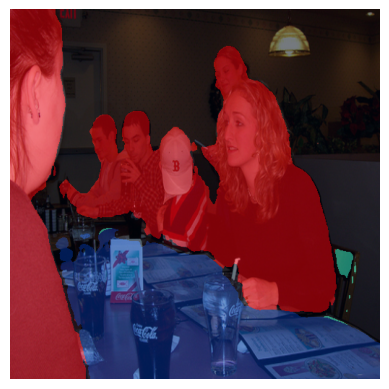

In [157]:
img_ = 1
image_gen.image_gen(inputs_s[img_], pred[img_], 0.5, save_fig = 'zs_city_2f', palette='voc')


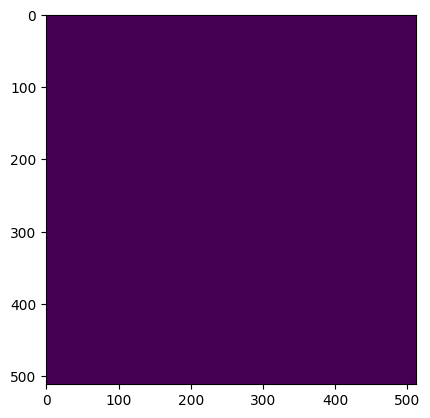

In [148]:
img_ = 3
plt.imshow(pred1[img_].cpu()==3); plt.show()
# plt.imshow(angles_full[img_,:,:,2].float().cpu); plt.show()
# plt.imshow(labels[img_].cpu(1); plt.show()

In [149]:
labels_exp = labels.unsqueeze(-1)
# Gather along the last dimension (dim=3)
angle__= torch.gather(angles_full, dim=3, index=labels_exp).squeeze(-1)
# c= torch.gather(c, dim=3, index=labels_exp).squeeze(-1)

In [158]:
with torch.no_grad():
    x = text_feats_d[labels]
    y = image_feats_d
    x_time = torch.sqrt(1 / 1 + torch.sum(x**2, dim=-1))
    y_time = torch.sqrt(1 / 1 + torch.sum(y**2, dim=-1))
    # Calculate lorentzian inner product multiplied with curvature. We do not use
    # the `pairwise_inner` implementation to save some operations (since we only
    # need the diagonal elements).
    # c_xyl = 1 * (torch.sum(x * y, dim=-1) - x_time * y_time)

In [52]:
from MERU_utils import manifold_conversion as mc
importlib.reload(mc)
im_poin = mc.lorentz_to_poincare(mc.spatial_to_lorentz(y))
poin_len = torch.sqrt((im_poin**2).sum(-1))

In [54]:
# mean_aero = mc.masked_lorentz_mean_direct(y, labels == 12 ) # compute the mean after l2k mean k2l
mean_aero2 = mc.masked_lorentz_mean_klein(y, labels == 11 )
dist_values = -L.pairwise_dist(y, mean_aero2[1:].unsqueeze(0))
angle_values = L.oxy_angle_full(y, mean_aero2[1:].unsqueeze(0)) 

In [161]:
angle_values = L.oxy_angle_full(y, text_feats_d[9].unsqueeze(0)) # exact angle corresponding to the prototypes. 

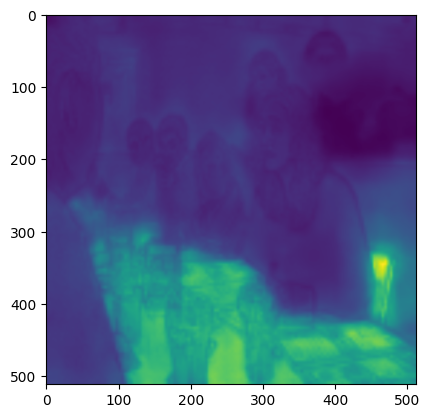

In [162]:
# plt.imshow(torch.exp(dist_values[img_]/0.2).cpu())
plt.imshow(torch.exp(-angle_values[img_]/0.5).cpu())


# plt.imshow(pred[5].cpu()==15)


In [73]:

a_vals, a_idxs = torch.min(angles_full, dim=-1)   # angle values and angle indexes # a index provides another inference methods
p_embed = torch.sqrt(torch.sum(y**2, dim=-1))/(1+y_time) # hyperboloid to poincare projection # magnitude
# p_embed = poin_len

# plot helper
img_ = 2
orig_img = inputs_s[img_].cpu().permute(1,2,0)

def uq_plot(orig_img, val, img_ = img_, pow_ = 2, save_name = 0):
    w_img = 0.2
    # val = a_vals # the source of the uncertainty p_embed for distance, and a_vals for angle entailment values
    val_ = (val[img_] - val[img_].min())/(val[img_].max() - val[img_].min()).cpu()

    mask = val_.unsqueeze(-1).cpu()**pow_ # (H, W)
    # Blend with original image
    overlay =  w_img*orig_img  + (1 - w_img) * mask.cpu()
    plt.imshow(overlay)
    plt.axis("off")
    
    plt.savefig('figure/boundary_zs_city_cycle_1' +str(save_name)+ '.svg', format = 'svg' )

    plt.show()
    
uq_plot(orig_img, a_vals**3, pow_ = 1, save_name = 0)
uq_plot(orig_img, p_embed**2, pow_= 0.8, save_name = 1)

# uq_plot(orig_img, y_time)

# plt.imshow(torch.acosh(y_time[img_]).cpu())


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


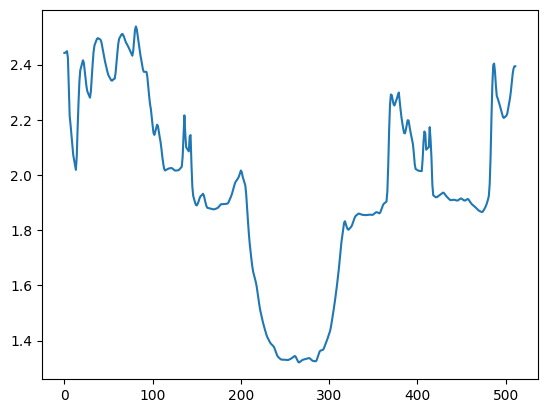

In [80]:
plt.plot(a_vals[img_, 280, :].cpu())

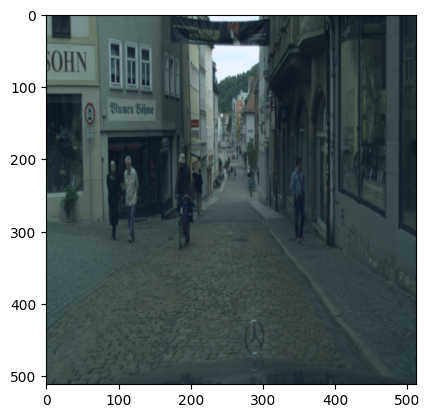

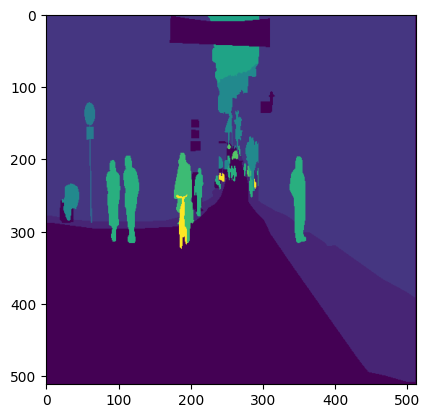

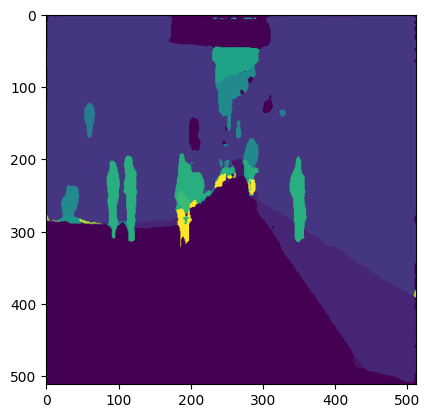

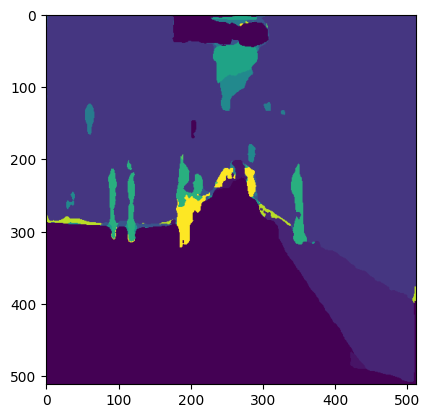

In [121]:
img_ = 2
with torch.no_grad():
    pred = model(inputs, None)["logits"] #
    pred = torch.argmax(pred, dim=-1)
import matplotlib.pyplot as plt
plt.imshow(inputs_s[img_].cpu().permute(1,2,0)); plt.show()
plt.imshow(labels[img_].int().cpu()); plt.show()
plt.imshow(pred[img_].int().cpu()); plt.show()
plt.imshow(a_idxs[img_].int().cpu()); plt.show()
# plt.imshow(labels[img_].int().cpu()-pred[img_].int().cpu()); plt.show()

double check these functions for correct results


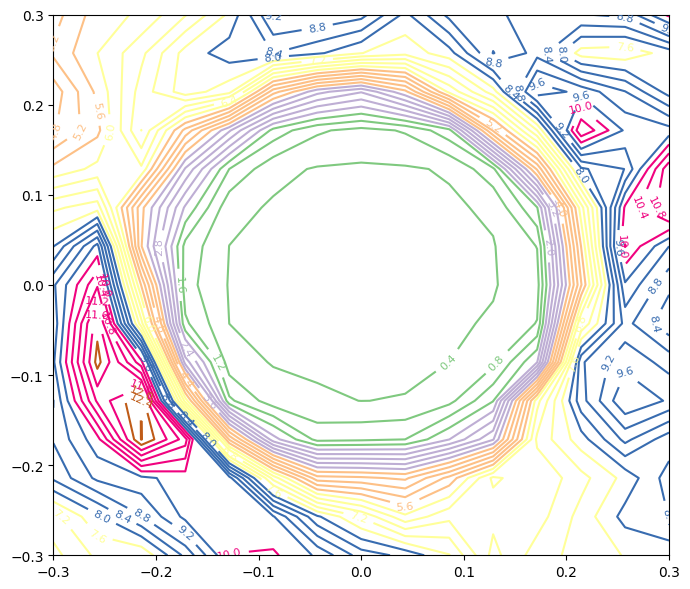

In [41]:
import Utils_Loss_Vis.filt_norm_lv 
# normalized filter visualization

importlib.reload(Utils_Loss_Vis.filt_norm_lv)

from Utils_Loss_Vis.filt_norm_lv import get_filter_normalized_directions, perturb_model, plot_loss_contour_lines, loss_surface_for_modules

print('double check these functions for correct results')

layers_to_plot = ['backbone', 'head']
a, b, Z_all = loss_surface_for_modules(model, layers_to_plot, inputs, labels, grid_size=15, span=0.3)
plot_loss_contour_lines(a, b, Z_all, f"Loss Surface — {layers_to_plot}", 'deeplabv3meru_voc-citnanjdaehnmor_new.15')

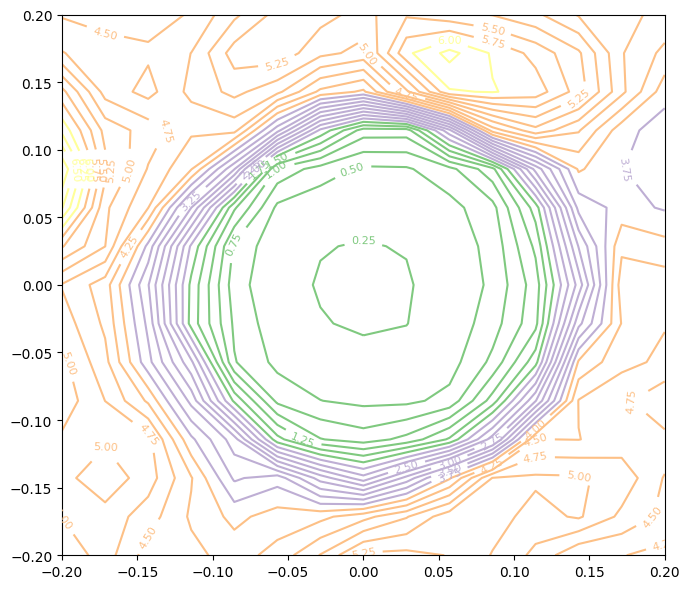

In [14]:
importlib.reload(Utils_Loss_Vis.filt_norm_lv)
from Utils_Loss_Vis.filt_norm_lv import get_filter_normalized_directions, perturb_model, plot_loss_contour_lines, loss_surface_for_modules

plot_loss_contour_lines(a, b, Z_all, f"Loss Surface — {layers_to_plot}", 'deeplabv3meru_coco-meru_set.15')

In [548]:
a = torch.randn((1, 8))
a_s = L.exp_map0(a)
a_t =torch.sqrt(torch.pow(a_s, 2).sum(1) +1 )
a_tt = torch.cosh(torch.sqrt((a**2).sum()))
a_t - a_tt

tensor([0.])

In [549]:
torch.sqrt(a_tt**2 -1) - torch.sqrt(torch.pow(a_s, 2).sum(1))

tensor([4.7684e-07])

In [47]:

### delta hyperbolicity computations
with torch.no_grad():
        encoder_outputs = model.encoder(inputs, output_hidden_states=True)
        hidden_states = encoder_outputs.hidden_states  # list of [B, C, H, W] feature maps
        re_feats = hidden_states[1].permute(0,2,3,1).reshape(-1, 128).cpu()

# with torch.no_grad():
#         outputs = model.backbone(inputs)
#         hidden_states = outputs['out']
#         re_feats = hidden_states.permute(0,2,3,1).reshape(-1, 2048).cpu()
        

# delta hyperbolicity computations


def delta_hyp_torch(dismat):
    p = 0
    row = dismat[p, :][None, :]
    col = dismat[:, p][:, None]
    XY_p = 0.5 * (row + col - dismat) # gromov product here
    maxmin = torch.minimum(XY_p[:, :, None], XY_p[None, :, :]).max(1).values
    return (maxmin - XY_p).max()
import numpy as np

idx = np.random.choice(len(re_feats), 2000)
all_features_small = re_feats[idx]
# dists = distance_matrix(all_features_small, all_features_small)
dists = torch.cdist(all_features_small, all_features_small)
# dists = gromov_product(all_features_small, all_features_small)

delta = delta_hyp_torch(dists)
diam = torch.max(dists)
del_rel =  2*delta/diam
print('delta relative: ', del_rel)
c = (0.144 / del_rel) ** 2
print('c value: ', c)

delta relative:  tensor(0.3035)
c value:  tensor(0.2251)


In [39]:
import torch

print("PyTorch δ-hyperbolicity computation (matches 1904.02239)")

@torch.no_grad()
def pairwise_euclid(x: torch.Tensor) -> torch.Tensor:
    """Compute pairwise Euclidean distance matrix for x: (n,d)."""
    x2 = (x**2).sum(-1, keepdim=True)
    D2 = x2 + x2.T - 2*(x @ x.T)
    D2.clamp_(min=0)
    return D2.sqrt()

@torch.no_grad()
def gromov_product_matrix(D: torch.Tensor, r: int) -> torch.Tensor:
    """Compute Gromov product matrix at basepoint r."""
    Dr = D[:, r].unsqueeze(0)         # (1,n)
    A = (Dr.T + Dr - D) * 0.5         # (n,n)
    return A

@torch.no_grad()
def max_min_product(A: torch.Tensor, k_chunk: int = 512) -> torch.Tensor:
    """Memory-efficient max-min product C[i,j] = max_k min(A[i,k], A[k,j])."""
    n = A.shape[0]
    device = A.device
    C = torch.full((n, n), -torch.inf, device=device, dtype=A.dtype)

    for start in range(0, n, k_chunk):
        stop = min(start + k_chunk, n)
        left  = A[:, start:stop].unsqueeze(2)   # (n, b, 1)
        right = A[start:stop, :].unsqueeze(0)   # (1, b, n)
        cand = torch.minimum(left, right)       # (n, b, n)
        C = torch.maximum(C, cand.amax(dim=1))
        del left, right, cand
    return C

@torch.no_grad()
def delta_r_from_D(D: torch.Tensor, r: int, k_chunk: int = 2048) -> float:
    """Compute δ_r at a given basepoint r."""
    A = gromov_product_matrix(D, r)
    C = max_min_product(A, k_chunk=k_chunk)
    delta_r = (C - A).max().item()
    return max(delta_r, 0.0)

@torch.no_grad()
def delta_star_2approx_from_D(D: torch.Tensor, r: int | None = None, k_chunk: int = 2048) -> float:
    """2-approximation of δ* using one basepoint."""
    n = D.shape[0]
    if r is None:
        # Pick farthest-from-median heuristic
        s = D.sum(dim=1)
        m = int(s.argmin().item())
        r = int(D[m].argmax().item())
    return delta_r_from_D(D, r, k_chunk=k_chunk)

@torch.no_grad()
def delta_from_points(x: torch.Tensor, exact: bool = False, k_chunk: int = 2048, base: int | None = None):
    """Compute δ (exact or 2-approx) from points x: (n,d)."""
    D = pairwise_euclid(x)
    return (delta_star_2approx_from_D(D, r=base, k_chunk=k_chunk) if not exact
            else delta_star_exact_from_D(D, k_chunk=k_chunk))

@torch.no_grad()
def relative_delta_from_D(D: torch.Tensor, delta_val: float) -> float:
    """Compute relative δ_hyperbolicity: δ_rel = 2 * δ / diam."""
    diam = float(D.max().item())
    return (2 * delta_val / diam) if diam > 0 else 0.0

PyTorch δ-hyperbolicity computation (matches 1904.02239)


In [49]:
# usage of the earlier section.
from math import ceil
# 2-approximation δ (fast)
delta_val = delta_from_points(text_feats_c, exact=False, k_chunk=512)  
print("δ (2-approx):", delta_val)

D = pairwise_euclid(all_features_small)               # distance matrix (2000x2000)
delta_rel = relative_delta_from_D(D, delta_val)
print("Relative δ:", delta_rel)

δ (2-approx): 0.16100147366523743
Relative δ: 0.30789076837149926


In [1]:
!pip install scipy
!pip install --upgrade pip

In [36]:
# mask2former: requires integration latter. 

import torch
import torch.nn as nn
from transformers import Mask2FormerForUniversalSegmentation

class CustomMask2Former(nn.Module):
    def __init__(self, pretrained_name="facebook/mask2former-swin-small-ade-semantic",
                 num_classes=5, freeze_backbone=False):
        super().__init__()
        # Load pretrained Mask2Former
        self.model = Mask2FormerForUniversalSegmentation.from_pretrained(pretrained_name)

        # Optionally freeze backbone and decoder parts
        if freeze_backbone:
            for param in self.model.model.encoder.parameters():
                param.requires_grad = False
            for param in self.model.model.pixel_decoder.parameters():
                param.requires_grad = False
            for param in self.model.model.transformer_decoder.parameters():
                param.requires_grad = False

        # Replace classification predictor with custom head
        hidden_dim = self.model.class_predictor.in_features
        self.model.class_predictor = nn.Linear(hidden_dim, num_classes + 1)  # +1 for "no-object"
        nn.init.xavier_uniform_(self.model.class_predictor.weight)
        nn.init.zeros_(self.model.class_predictor.bias)

    def forward(self, pixel_values, mask_labels=None, class_labels=None):
        return self.model(pixel_values=pixel_values,
                          mask_labels=mask_labels,
                          class_labels=class_labels)


In [37]:
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-ade-semantic")

In [11]:
# integrate the MMsegmentation in the next stage. 
#https://github.com/open-mmlab/mmsegmentation

In [16]:
# segformer Model experimentations
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerModel

# ----------------------------
# 1. Setup device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 2. Load SegFormer (pretrained on ADE20K, can be finetuned on COCO)
# ----------------------------
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512").to(device)

encoder = SegformerModel.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", ignore_mismatched_sizes=True)
    

feature_extractor = SegformerFeatureExtractor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)


/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:35: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  super().__init__(*args, **kwargs)


In [17]:
with torch.no_grad():
    feats = encoder(inputs.cpu(), output_hidden_states=True)
    feats2 = model.segformer.encoder(inputs.cuda(), output_hidden_states=True)

In [24]:
len(feats2.hidden_states)

4

In [ ]:
# extra codes
# no need to run it now

with torch.no_grad():
    output = model(input_tensor)['out'] 
    output_feat =  model.backbone(input_tensor) # feature extraction
    
import torch.nn as nn

with torch.no_grad():
    outputs =  model.classifier(output_feat['out'])
    outputs = nn.functional.interpolate(outputs, size=(512, 512), mode='bilinear', align_corners=False)
    
    # equivalent to the direct output got in the earlier state
    
# inits
# check block: works fine
import torch.nn as nn

print('init image alpha: ', (image_feats_m.cpu().detach()**2).sum(dim=1).sqrt().mean())

print('init text alpha', (text_feats_pca**2).sum(-1).sqrt().mean())

curv_init = 1
curv = nn.Parameter(
            torch.tensor(curv_init).log(), requires_grad=False)

# load text feature
text_feats_pca = torch.load("class_embeddings_word/Ade_151_pca_bse1_5_64D.pt")
text_feats = text_feats_pca.squeeze(dim = 1)
embed_dim = text_feats.shape[-1]
textual_alpha = nn.Parameter(torch.tensor(0.6**-1).log(), requires_grad= False)

# image features
image_features = image_feats_m # torch.randn(BS, 64, H, W)  # find it from the Network 
image_alpha =  nn.Parameter(torch.tensor(4**-1).log(), requires_grad= False)

_curv = curv.exp()

# Exponential mapping
# scaling
text_feats = text_feats * textual_alpha.exp()
image_features = image_features.permute(0, 2, 3, 1) * image_alpha.exp()

# exp mapping at origin
with torch.autocast('cuda', dtype=torch.float32):
    text_feats = L.exp_map0(text_feats, curv.exp())## Text Features # one time calculation: fixed but depends on the textual alpha
    image_feats = L.exp_map0(image_features, curv.exp())

# ----------------------------
# 1) Apply a 2D perturbation (alpha, beta) for multiple modules
# ----------------------------
@torch.no_grad()
def perturb_model(base_model: nn.Module,
                  module_names,  # list of module names or None
                  dirs1, dirs2,
                  alpha: float, beta: float) -> nn.Module:
    """
    Returns a deep-copied model where parameters are perturbed by alpha*dirs1 + beta*dirs2.
    If module_names=None, perturb ALL layers.
    """
    model = copy.deepcopy(base_model)

    if module_names is None:
        # Apply to all parameters
        for p, d1, d2 in zip(model.parameters(), dirs1, dirs2):
            if p.requires_grad and d1 is not None and d2 is not None:
                p.add_(alpha * d1 + beta * d2)
    else:
        # Apply to all selected modules
        idx = 0
        for module_name in module_names:
            submod = dict(model.named_modules())[module_name]
            for p in submod.parameters():
                if p.requires_grad:
                    d1, d2 = dirs1[idx], dirs2[idx]
                    if d1 is not None and d2 is not None:
                        p.add_(alpha * d1 + beta * d2)
                    idx += 1
    return model


# ----------------------------
# 2) Evaluate loss on a 2D grid for multiple modules
# ----------------------------
def loss_surface_for_modules(model: nn.Module,
                             module_names,  # list of str or None
                             x: torch.Tensor,
                             labels: torch.Tensor,
                             grid_size: int = 21,
                             span: float = 1.0,
                             seed1: int = 123, seed2: int = 456):
    """
    Computes a grid Z of losses by perturbing the specified modules along two
    independent filter-normalized directions.
    If module_names=None, perturbs ALL parameters in the model.
    """
    device = next(model.parameters()).device
    model.eval()

    # Build directions for all selected modules
    dirs1, dirs2 = [], []
    if module_names is None:
        dirs1 = get_filter_normalized_directions(model, seed=seed1)
        dirs2 = get_filter_normalized_directions(model, seed=seed2)
    else:
        for module_name in module_names:
            submod = dict(model.named_modules())[module_name]
            dirs1.extend(get_filter_normalized_directions(submod, seed=seed1))
            dirs2.extend(get_filter_normalized_directions(submod, seed=seed2))

    alphas = np.linspace(-span, span, grid_size)
    betas = np.linspace(-span, span, grid_size)
    Z = np.zeros((grid_size, grid_size), dtype=np.float64)

    with torch.no_grad():
        for i, a in enumerate(alphas):
            for j, b in enumerate(betas):
                perturbed = perturb_model(model, module_names, dirs1, dirs2, a, b)
                perturbed.eval()
                out = perturbed(x, labels)
                loss_val = out["loss"].item() if isinstance(out, dict) and "loss" in out else float(out)
                Z[i, j] = loss_val

    return alphas, betas, Z


# ----------------------------
# Example usage:
# ----------------------------
# Perturb multiple layers
layers_to_plot = ['backbone', 'feats', 'head']
a, b, Z_all = loss_surface_for_modules(model, layers_to_plot, inputs, labels, grid_size=15, span=0.5)
plot_loss_contour(a, b, Z_all, f"Loss Surface — {layers_to_plot}")


##

with torch.no_grad():
    in_values = L.pairwise_dist(image_feats_d, text_feats_d, model.curv.exp())
    _angles =  L.oxy_angle(text_feats_d[labels], image_feats_d, model.curv.exp())
    _angle, _distance, _aperture = L.oxy_angle_modified(image_feats_d,text_feats_d, labels = labels, curv=model.curv.exp()) 
    
# pair wise distance: im_feat: (bs, h, w, D), text_feats(class_number, D)
with torch.autocast('cuda', dtype=torch.float32):
    xy_dist = - L.pairwise_dist(image_feats_d.cuda(), text_feats_d.cuda()) # no need for the reshaping. 
# also work of L.pairwise_inner (bs, H, W, class_number)
xy_dist.permute(0,3,1,2).shape

In [ ]:
print('Training loop for the Baseline: No hyperbolic')
import random
import pdb
for epoch in range(15):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        try:
            inputs, labels  = data
        except: 
            inputs, labels, _ = data # for ade and cocostuff dataset
        # inputs, labels = data # for citiscape
        inputs = inputs.to(device)
        labels = labels.squeeze().to(device)
        inputs, labels  = _augmentation_gpu(inputs.float(), labels, augmentation_num = random.randint(0, 0), im_size= im_size) # input -> bs, 3, h, w ; labels -> bs, h, w
        inputs = dl_preprocess(inputs.float()/255.0).to(device) # deeplab specific transformation. 
        # be mindful to check the image size after the augmentation for testing. 
        
        labels = labels.long()
        
        break
        optimizer.zero_grad()
        
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()


        if i% 1000 ==0:
            pred = torch.argmax(outputs, dim=1)
            # Check if predictions match the ground truth (shape: B, H, W)
            correct = (pred == labels).float()  # Convert to float to compute mean
            # Compute the pixel-wise accuracy
            accuracy = correct.sum() / (labels.numel())  # numel() gives total number of elements
            print('Accuracy: ', accuracy)
            print('loss value: ', loss.item())

        
        
print('Finished Training')